<a href="https://colab.research.google.com/github/aar0np/genai-cookbook/blob/main/Airbyte_xkcd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Querying an Astra DB collection with an Airbyte Cloud data pipeline.

This notebook will walk through how to build a simple application using a data pipeline from Airbyte Cloud. Our Airbyte Cloud pipeline will pull data from the XKCD API, and store it in Astra DB. Our application will then be able to run similarity searches on the vector embeddings to bring back data on the most-similar XKCD comic.

Requirements:
*   A free account and vector database with [Astra DB](https://astra.datastax.com).
*   A free account with [Airbyte](https://www.airbyte.com).
*   An [OpenAI](https://openai.com/) API key.

## Setup

Install the DataStax RAGStack and Matplotlib libraries.

In [16]:
!pip install ragstack-ai matplotlib

## Library Imports

In [25]:
from astrapy.db import AstraDB
from langchain_openai import OpenAIEmbeddings
from getpass import getpass
from PIL import Image
from matplotlib import image as mpimg
from urllib.request import urlopen

## Environment Variables

In [4]:
ASTRA_DB_APPLICATION_TOKEN = getpass('Your Astra DB Token ("AstraCS:..."): ')

Your Astra DB Token ("AstraCS:..."): ··········


In [5]:
ASTRA_DB_API_ENDPOINT = input('Your Astra DB API endpoint: ')
ASTRA_DB_KEYSPACE_NAME='default_keyspace'
ASTRA_DB_COLLECTION_NAME='airbyte'

Your Astra DB API endpoint: https://cab00884-ea42-4e4e-a426-e4199fb25536-us-east1.apps.astra.datastax.com


In [6]:
OPENAI_API_KEY = getpass('Your OpenAI API Key ("sk-..."): ')

Your OpenAI API Key ("sk-..."): ··········


## Define the OpenAI "text-embedding-ada-002" embedding model.

In [8]:
model = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

## Connect to Astra DB

In [10]:
db = AstraDB(
    token=ASTRA_DB_APPLICATION_TOKEN,
    api_endpoint=ASTRA_DB_API_ENDPOINT,
    namespace=ASTRA_DB_KEYSPACE_NAME,
)
collection = db.collection(ASTRA_DB_COLLECTION_NAME)

## Define your query

In [39]:
query = input('Enter your query ("Kepler" is the default): ')

if query == "":
  query = "Kepler"

Enter your query ("Kepler" is the default): tar


## Generate a vector embedding of your query's text

In [40]:
print(f'query="{query}"')
vector = model.embed_query(query)
print(f'vector="{vector}"')

query="tar"
vector="[0.0067335637662384405, -0.02769478425950332, -0.0011013341197787776, -0.04172872402728266, -0.012993589116188265, -0.0025219472731688192, -0.025657137999186126, -0.034726102099057646, -0.008473455953239747, -0.02702035211216753, 0.022414121902005243, 0.03891619689146092, -0.00511923016114162, 0.0025649962624369927, -0.002272622672495353, 0.013739770355073162, 0.04508653680829695, 0.00718916444397849, 0.01743480014107793, -0.02034777414242325, -0.0223854222653856, -0.0010717379687607393, -0.02624547309930815, -0.002023297838991242, -0.02010383095644661, 0.004032245859672663, 0.024451768162322435, -0.024982703989205178, 0.007483331994039502, -0.015425851654735218, 0.012111087397327809, -0.015655445022402036, -0.019745089223991402, -0.039719775540939944, -0.03584537302606241, -0.006292312441146922, 0.0003921484771200585, -0.016702968720502854, 0.015626747248427553, -0.012885967341509768, 0.015554998156878448, 0.006823248733690952, 0.009556853265792538, -0.007246562785

## Store and print the result

In [41]:
result = collection.vector_find_one(vector,fields=['title','img','alt'])

print(result)

{'_id': 'b0f5b11f-0b96-4ba9-a90b-384c3ca684d2', 'title': 'Trum-', 'img': 'https://imgs.xkcd.com/comics/trum.png', 'alt': 'Excited to vote for future presidents Bill Eisenhamper, Amy Forb, Ethan Obample, and Abigail Washingtoast.', '$similarity': 0.8993033}


## Display the xkcd webcomic

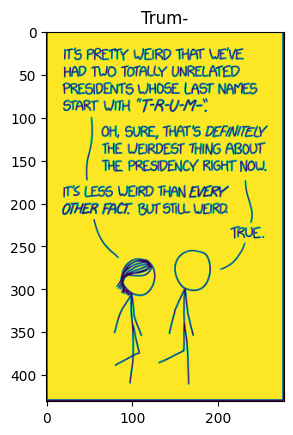

Excited to vote for future presidents Bill Eisenhamper, Amy Forb, Ethan Obample, and Abigail Washingtoast.


In [43]:
plt.title(result['title'])
pil_image = Image.open(urlopen(result['img']))
plt.imshow(pil_image)
plt.show()
print(result['alt'])